# Onchain Onboarders

###  RPGF3 List ✨

In [1]:
from itertools import combinations
import json
import networkx as nx
import numpy as np
import pandas as pd

from scripts.oso_db import execute_query
from scripts.eas_lists import OsoData, listify, create_eas_json

# Prep

In [2]:
# settings

DATA_DIR  = "data/RPGF3/"
DATA_PATH = DATA_DIR + "2023-11_06_RPGF3_cleaned_applicant_data.json"

LIST_DESC = "This list rewards projects that onboarded active users to OP Mainnet (powered by Open Source Observer)."
LINK_BASE = "https://github.com/opensource-observer/insights/blob/main/notebooks/"
FILENAME  = "2023-11-15_RPGF3_OnchainOnboarders.ipynb"
LIST_LINK = LINK_BASE + FILENAME

LIST_EVAL = " ".join([
                "This is an experimental list format that rewards protocols for onboarding active users to OP Mainnet.",
                "Only projects with unique, public GitHub repos AND at least one contract address",
                "included in their RPGF3 application are considered in this analysis.",
                "The algorithm works by first identifying addresses that have: (a) at least 30 transactions on OP Mainnet,"
                "(b) at least 10 distinct days of activity, (c) at least one transaction in the last 90 days,"
                "(d) and interactions with at least 3 different protocols on OP Mainnet. Next, it identifies the first",
                "three protocols those users interacted with. Finally, it assigns tokens based on the log",
                "of these scores. For more details, please see the Impact Evaluation notebook linked to this list."
                ]) 

LIST_CATS = [
            #'COLLECTIVE_GOVERNANCE',
            #'DEVELOPER_ECOSYSTEM', 
            'END_USER_EXPERIENCE_AND_ADOPTION', 
            #'OP_STACK'
            ]

AWARD_AMT = 2 * 10e6

JSON_PATH = DATA_DIR + "lists/OSO_OnchainOnboarders.json"

In [3]:
# ingest data

oso = OsoData(DATA_PATH)
slugs = list(oso.get_project_slugs())
slugs.remove('polynomial-protocol') # RPGF3 project is for off-chain work
slugs_to_ids = oso.map_slugs_to_ids()

Loaded 311 OSS projects from data/RPGF3/2023-11_06_RPGF3_cleaned_applicant_data.json.
Identified 311 unique slugs.


# Get the data to power the list

In [4]:
# run query (may take a few minutes)

slugs_list = "','".join(slugs)

query = f"""
SELECT
    e."fromId",
    COUNT(DISTINCT p.slug) AS total_slugs,
    SUM(e."amount") AS total_txns,
    COUNT(DISTINCT e.time) AS total_days,
    MAX(e."time") AS last_txn
FROM
    event e
LEFT JOIN
    project_artifacts_artifact paa ON e."toId" = paa."artifactId"
LEFT JOIN
    project p ON paa."projectId" = p."id"
WHERE
    p.slug IN ('{slugs_list}')
    AND e."typeId" = 25
GROUP BY
    e."fromId";

"""
results = execute_query(query, col_names=True)

In [5]:
query = f"""
WITH ranked_events AS (
    SELECT
        e."fromId",
        p.slug AS slug,
        e.time,
        ROW_NUMBER() OVER (PARTITION BY e."fromId" ORDER BY e.time) AS rn
    FROM
        event e
    LEFT JOIN
        project_artifacts_artifact paa ON e."toId" = paa."artifactId"
    LEFT JOIN
        project p ON paa."projectId" = p."id"
    WHERE
        e."typeId" = 25
)
SELECT
    "fromId",
    MAX(CASE WHEN rn = 1 THEN slug END) AS first_interacted_slug,
    MAX(CASE WHEN rn = 2 THEN slug END) AS second_interacted_slug,
    MAX(CASE WHEN rn = 3 THEN slug END) AS third_interacted_slug
FROM
    ranked_events
WHERE
    rn <= 3
GROUP BY
    "fromId";

"""
ranked_events = execute_query(query, col_names=True)

In [6]:
# combine results from both queries

raw_df = pd.DataFrame(results[1:], columns=results[0])
raw_df['last_txn'] = raw_df['last_txn'].dt.strftime('%Y-%m-%d')

ranked_events_df = pd.DataFrame(ranked_events[1:], columns=ranked_events[0]).set_index('fromId')
raw_df = ranked_events_df.join(raw_df.set_index('fromId'))
raw_df.head()

,first_interacted_slug,second_interacted_slug,third_interacted_slug,total_slugs,total_txns,total_days,last_txn
fromId,,,,,,,
2.0,safe-global,safe-global,safe-global,NaN,NaN,NaN,NaN
81.0,zora,zora,safe-global,1.0,5.0,1.0,2023-05-10
110.0,safe-global,safe-global,safe-global,NaN,NaN,NaN,NaN
177.0,safe-global,safe-global,safe-global,NaN,NaN,NaN,NaN
184.0,uniswap,None,None,NaN,NaN,NaN,NaN


In [7]:
# filter results

print(f"Feteched a total of {len(raw_df)} addresses.")
df = raw_df.copy().dropna(axis=0)

df.reset_index(inplace=True)
print(f"A total of {len(df)} addresses interacted with a RPGF3 protocol.")

tx_threshold = 30
df = df[df['total_txns']>=tx_threshold]
print(f"A total of {len(df)} addresses interacted at least {tx_threshold} times.")

active_days = 10
df = df[df['total_days']>=active_days]
print(f"A total of {len(df)} addresses had at least {active_days} active days.")

date_thresh = '2023-08-15'
df = df[df['last_txn'] >= date_thresh]
print(f"A total of {len(df)} addresses have been active since {date_thresh}.")

project_thresh = 3
df = df[df['total_slugs']>=project_thresh]
print(f"A total of {len(df)} addresses interacted with at least {project_thresh} protocols.")

df.head()

Feteched a total of 3557776 addresses.
A total of 1107827 addresses interacted with a RPGF3 protocol.
A total of 101886 addresses interacted at least 30 times.
A total of 80568 addresses had at least 10 active days.
A total of 57257 addresses have been active since 2023-08-15.
A total of 47563 addresses interacted with at least 3 protocols.


,fromId,first_interacted_slug,second_interacted_slug,third_interacted_slug,total_slugs,total_txns,total_days,last_txn
18,2518.0,velodrome,velodrome,velodrome,7.0,791.0,196.0,2023-10-18
31,7810.0,synapse,synapse,synapse,3.0,200.0,46.0,2023-11-09
34,8112.0,op,op,sushi,6.0,252.0,41.0,2023-11-02
53,10612.0,1-inch,op,1-inch,3.0,37.0,10.0,2023-09-26
55,10689.0,ripae,ripae,ripae,3.0,71.0,20.0,2023-09-08


In [8]:
# give attribution weights to the first protocols a user interacted with

scores = {}
for slug in slugs:
    score = df[df['first_interacted_slug'] == slug]['fromId'].nunique() * .5
    score += df[df['second_interacted_slug'] == slug]['fromId'].nunique() * .3
    score += df[df['third_interacted_slug'] == slug]['fromId'].nunique() * .2
    if score:
        scores[slug] = score

In [9]:
# apply a logarithm to bucket projects by orders of magnitude of impact

logscores = {k: np.ceil(np.log10(v))+1 for k,v in scores.items()}
amounts = {k: v*25000 for k,v in logscores.items()}

# Generate the list

In [10]:
rpgf_list = {slugs_to_ids[k]:v for k,v in amounts.items()}

<AxesSubplot:>

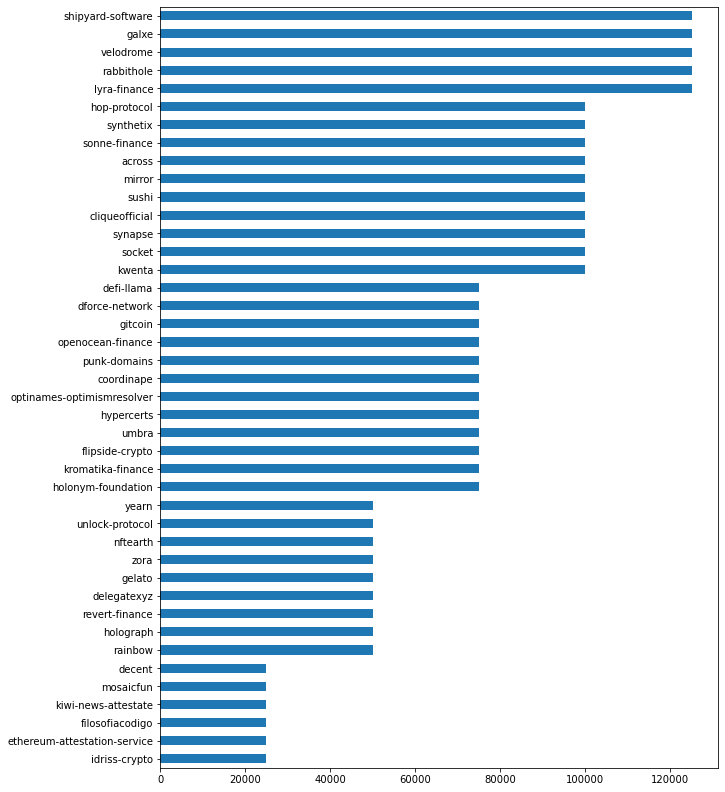

In [12]:
series = pd.Series(amounts).sort_values()
series = series[series>0]
series.plot(kind='barh', figsize=(10,len(rpgf_list)/3))

In [13]:
eas_metadata = create_eas_json(rpgf_list, LIST_DESC, LIST_LINK, LIST_EVAL, LIST_CATS)

In [14]:
with open(JSON_PATH, "w") as f:
    json.dump(eas_metadata, f, indent=4)

# Visualize results

In [16]:
import plotly.express as px

In [25]:
px.treemap(
    data_frame=df[df['first_interacted_slug'].isin(slugs)], 
    path=['first_interacted_slug'],
    values='total_txns'
)

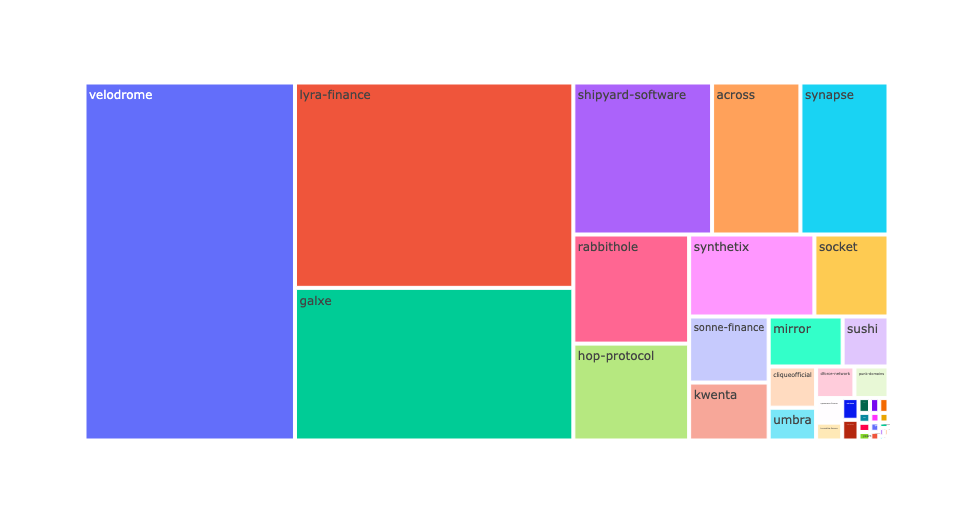